## SVC Model Using Count Vectors and Unigram
#### Jonathan Fred Braganza 500223773

In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
import contractions
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
text = pd.read_csv('Sentiment_Data.csv', encoding='ISO-8859-1')
pd.set_option('display.max_colwidth', 100)
text.head()

,Tweet,Sentiment
0,"@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ""A...",Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Do...,Mild_Pos
3,"@NChartierET Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ""Ame...",Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ...,Mild_Pos


In [3]:
text.shape

(451332, 2)

In [4]:
def extract_features(text: str) -> pd.Series:
    """
    Extracts features from a text.

    Parameters:
    text: str
        The text to extract features from.

    Returns:
    pd.Series
        A pandas series containing the extracted features.
    """
    
    # hashtags
    hashtags = re.findall(r'#\w+', text)
    num_hashtags = len(hashtags)
    has_hashtags = int(num_hashtags > 0)
    
    # mentions
    mentions = re.findall(r'@\w+', text)
    num_mentions = len(mentions)
    has_mentions = int(num_mentions > 0)
    
    # words
    words = text.split()
    num_words = len(words)
    
    # characters
    num_chars = len(text)
    
    # uppercase words
    num_upper = len([word for word in words if word.isupper()])
    
    # exclamation marks
    num_excl = text.count('!')
    
    # question marks
    num_quest = text.count('?')
    
    # emojis
    num_emojis = len([char for char in text if char in emoji.EMOJI_DATA])
    
    # URLs
    num_urls = len(re.findall(r'\w+:\/\/\S+', text))
    
    return pd.Series([has_hashtags, num_hashtags, has_mentions, num_mentions, num_words, num_chars, num_upper, num_excl, num_quest, num_emojis, num_urls])

text['Tweet_processed'] = text['Tweet'].astype(str)
features = text['Tweet_processed'].apply(extract_features)
text = pd.concat([text, features], axis=1)
text.columns = ['Tweet', 'Sentiment', 'Tweet_processed', 'Has_Hashtags', 'Num_Hashtags', 'Has_Mentions', 'Num_Mentions', 'Num_Words', 'Num_Chars',
                 'Num_Upper', 'Num_Excl', 'Num_Quest', 'Num_Emojis', 'Num_URLs']

In [5]:
text.head()

,Tweet,Sentiment,Tweet_processed,Has_Hashtags,Num_Hashtags,Has_Mentions,Num_Mentions,Num_Words,Num_Chars,Num_Upper,Num_Excl,Num_Quest,Num_Emojis,Num_URLs
0,"@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ""A...",Mild_Pos,"@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ""A...",1,6,1,1,22,213,0,3,0,0,1
1,@McfarlaneGlenda Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ...,Mild_Pos,@McfarlaneGlenda Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ...,1,6,1,1,22,215,0,3,0,0,1
2,@thevivafrei @JustinTrudeau Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Do...,Mild_Pos,@thevivafrei @JustinTrudeau Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Do...,1,6,1,2,23,226,0,3,0,0,1
3,"@NChartierET Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ""Ame...",Mild_Pos,"@NChartierET Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ""Ame...",1,6,1,1,22,211,0,3,0,0,1
4,@tabithapeters05 Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ...,Mild_Pos,@tabithapeters05 Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's ...,1,6,1,1,22,215,0,3,0,0,1


#### Clean the data
- Check for null data
- Remove mentions
- Remove hashtags
- Remove hyperlinks/email adresses
- Remove punctuation
- Convert to lowercase
- Replace contractions
- Replace emojis or emoticons by their meanings
- Expanding abbreviations, acronyms, initialisms and slangs
- Remove stopwords
- Remove whitespaces in excess and numbers

### Slangs.csv (Bodhwani, n.d.). 
 Slangs.csv(GitHub - bodhwani/NLP-VIT-BOT) contains a rather extensive list of common slangs abbrievations and their fullforms which is being used below to handle the slangs in the Dataframe

    
    Bodhwani. (n.d.). GitHub - bodhwani/NLP-VIT-BOT: Bot to embedded in VIT’s official website. GitHub. https://github.com/bodhwani/NLP-VIT-BOT

In [6]:
#slangs_url = 'https://raw.githubusercontent.com/bodhwani/NLP-VIT-BOT/master/slangs.csv' by Bodhwani. (n.d.).
slangs_df = pd.read_csv('slangs.csv', usecols=['Abbr', 'Fullform'])

slang_map = dict(zip(slangs_df['Abbr'], slangs_df['Fullform']))


def replace_slangs(tweet):
    if isinstance(tweet, str):
            for word in tweet.split():
                if word in slang_map:
                    tweet = tweet.replace(word, slang_map[word])
    return tweet

def replace_emoticons(text):
    emoticon = pd.read_csv('emoticons.csv')
    emoticon_map = dict(zip(emoticon['emoticon'], emoticon['meaning']))
    for emot in emoticon_map:
        text = text.replace(emot, ' ' + emoticon_map[emot] + ' ')
    return text

def handle_negations(text):
    negation_patterns = ["n't", "not", "never", "no"]
    words = text.split()
    for i in range(len(words)):
        if words[i].lower() in negation_patterns:
            if i+1 < len(words):
                words[i+1] = "NOT_" + words[i+1] + " "
    return ' '.join(words)

# Function to clean the text
def clean_text(tweet):
    if isinstance(tweet, str):
        tweet = re.sub(r'@\w+', ' ', tweet)              # Remove mentions
        tweet = re.sub(r'#', ' ', tweet)                 # Remove hashtags
        tweet = re.sub(r'\w+:\/\/\S+', ' ', tweet)           # Remove hyperlinks
        tweet = re.sub(r'\S*@\S*\s?', ' ', tweet)        # Remove email addresses
        tweet = re.sub(r'[^\w\s]', ' ', tweet)           # Remove punctuation
        tweet = re.sub(r'[^a-zA-Z]+', ' ', tweet)           # Remove all non-English characters
        tweet = handle_negations(tweet)                  # Handle negations
        tweet = contractions.fix(tweet)                  # Expand contractions
        tweet = replace_emoticons(tweet)                 # Replace emoticons by their meanings
        tweet = emoji.demojize(tweet)                     # Replace emojis by their meanings
        tweet = replace_slangs(tweet)                    # Replace slangs by their meanings
        tweet = re.sub(r'\d+', ' ', tweet)             # Remove numbers
        tweet = tweet.lower()                            # Convert to lowercase
        
    return tweet



start_time = time.time()
text['Tweet_processed'] = text['Tweet_processed'].apply(clean_text)
elapsed_time = time.time() - start_time
print(f"Time taken for preprocessing: {elapsed_time:.2f} seconds")

Time taken for preprocessing: 506.86 seconds


In [7]:
# Check null rows and/or rows that are not string
print("Number of null rows: ", text['Tweet_processed'].isnull().sum())
print("Number of non-string rows: ", text.shape[0] - text['Tweet_processed'].apply(lambda x: isinstance(x, str)).sum())

Number of null rows:  0
Number of non-string rows:  0


In [8]:
text = text.dropna(subset=['Tweet_processed'])
text = text[text['Tweet_processed'].apply(lambda x: isinstance(x, str))]

#### Encoding the target variable

In [9]:
# Checking the unique values for the target variable
text['Sentiment'].value_counts()

Sentiment
Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: count, dtype: int64

In [10]:
# Applying label encoding to the target variable
label_mapping = {
    'Strong_Neg': -1,
    'Mild_Neg': -1,
    'Neutral': 0,
    'Mild_Pos': 1,
    'Strong_Pos': 1
}
text['Sentiment'] = text['Sentiment'].map(label_mapping)


# Sampled 50,000 rows to lower the runtime
text = text.sample(n=30000, random_state=42)

text['Sentiment'].value_counts()

Sentiment
 1    19729
-1     5147
 0     5124
Name: count, dtype: int64

In [11]:
# Tokenization, stop words removal, and stemming/lemmatization
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(tweet):
    if isinstance(tweet, str):
        tokens = word_tokenize(tweet)                            # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lemmatize
        tweet = ' '.join(tokens)
    return tweet

text['Tweet_processed'] = text['Tweet_processed'].apply(preprocess_text)

In [12]:
text[['Tweet', 'Tweet_processed']].head()

,Tweet,Tweet_processed
420483,stupid fucking freedom convoy is going past the store i work at stop fucking honking itâs so a...,stupid fucking freedom convoy going past store work stop fucking honking annoying
320604,Freedom Convoy coming to a country near you! Starting March 1st in the U.S. https://t.co/nucwFPnPc2,freedom convoy coming country near starting march st
68154,@CTVNews The main thing is that the Freedom/Anti-mandate convoy will cost Trudeau his job ! Many...,main thing freedom anti mandate convoy cost trudeau job many people woke drama teacher dictatori...
100473,"Residents who Chauvin says previously agreed to leave are no longer willing to leave, he says. S...",resident chauvin say previously agreed leave not_longer willing leave say uncomfortable proteste...
303998,MSNBC guest says Freedom Convoy truckers throwing a 'temper tantrum' https://t.co/55LnWeAmrM #Fo...,msnbc guest say freedom convoy trucker throwing temper tantrum foxnews okay blm antifa asswipes ...


In [13]:
#Drop the rows that do not contain any text
text = text[text['Tweet_processed'].apply(lambda x: len(x) > 0)]

In [14]:
# drop Tweet column
text = text.drop(columns=['Tweet'])

In [15]:
# Vectorize the text data
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
X = vectorizer.fit_transform(text['Tweet_processed'])

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(text['Sentiment'])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())



In [16]:
# Define kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor='k')
    ax.set_title(title)
    return scatter


Kernel: linear
Training Time: 53.97 seconds
Accuracy: 0.6809007506255212
ROC AUC Score: 0.6005181085859792
Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1040
     Neutral       0.38      0.50      0.43       970
    Positive       0.76      0.90      0.83      3985

    accuracy                           0.68      5995
   macro avg       0.38      0.47      0.42      5995
weighted avg       0.57      0.68      0.62      5995

Kernel: poly
Training Time: 160.18 seconds
Accuracy: 0.6912427022518766
ROC AUC Score: 0.6574459627835192
Classification Report:
               precision    recall  f1-score   support

    Negative       0.39      0.06      0.10      1040
     Neutral       0.43      0.39      0.41       970
    Positive       0.75      0.93      0.83      3985

    accuracy                           0.69      5995
   macro avg       0.52      0.46      0.45      5995
weighted avg       0.63      0.6

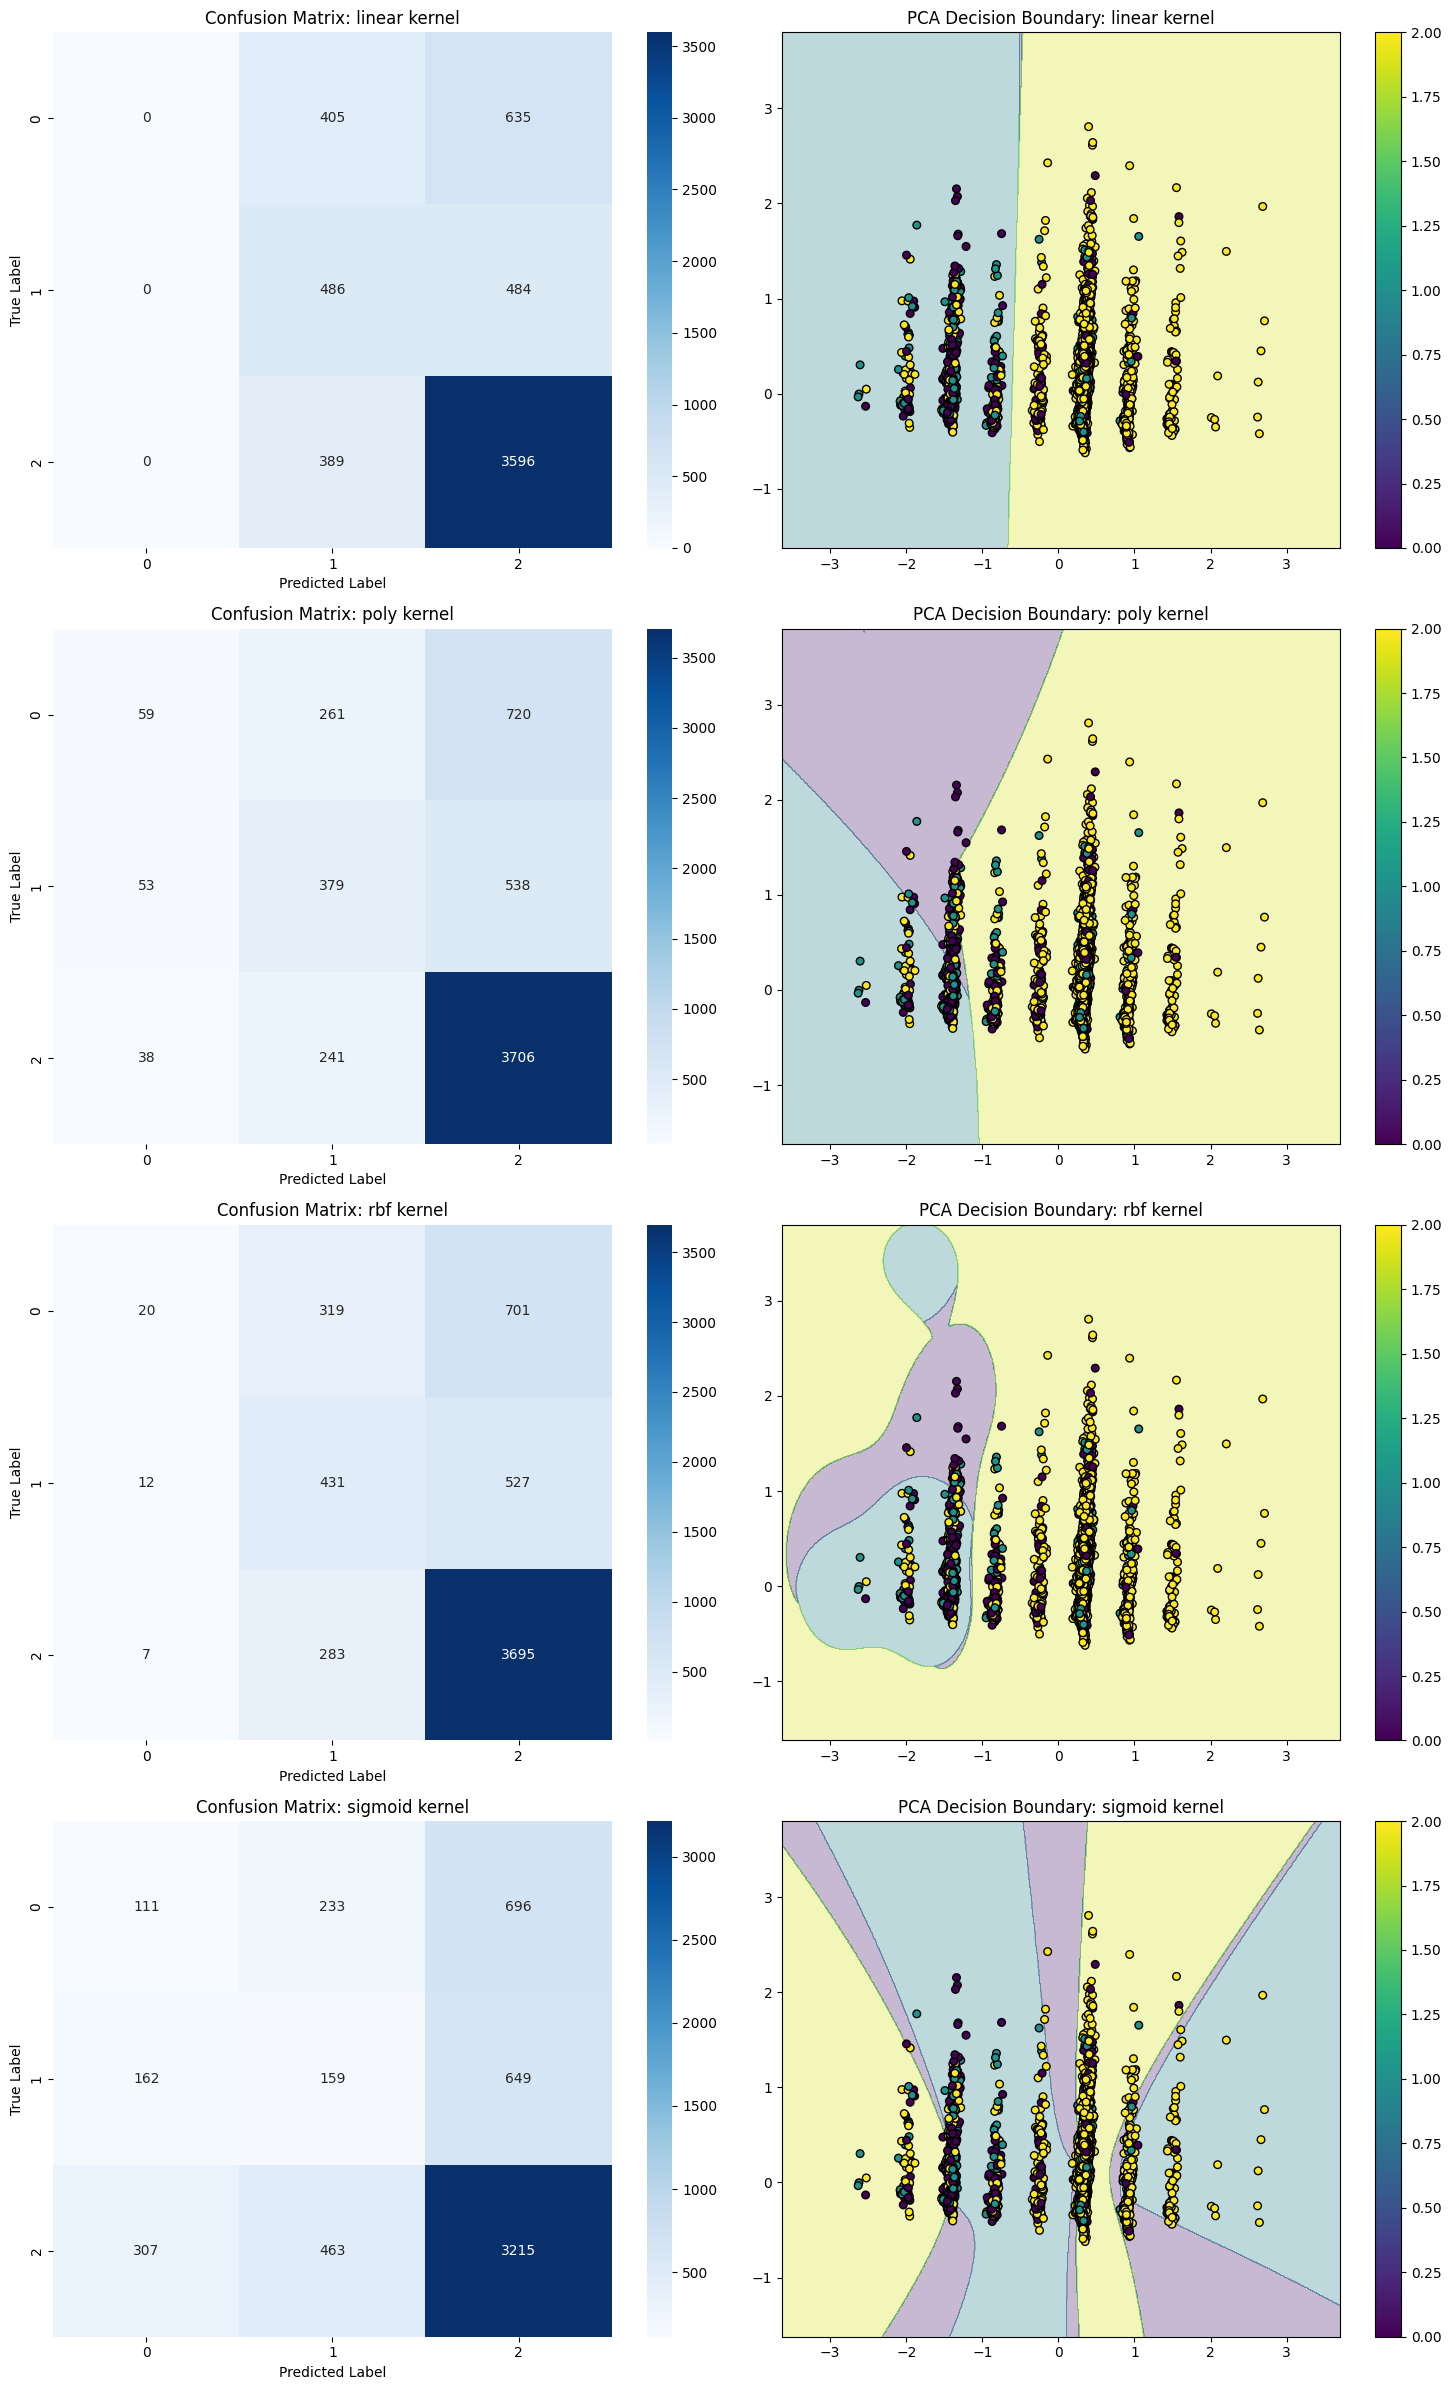

In [17]:
# Plot decision boundaries and evaluate each kernel
fig, axes = plt.subplots(4, 2, figsize=(15, 24))
axes = axes.flatten()

# Correct target names for classification report
target_names = ['Negative', 'Neutral', 'Positive']

for i, kernel in enumerate(kernels):
    svm_model = SVC(kernel=kernel, probability=True)
    start_time = time.time()
    svm_model.fit(X_train_pca, y_train)
    train_time = time.time() - start_time
    
    y_pred = svm_model.predict(X_test_pca)
    y_pred_proba = svm_model.predict_proba(X_test_pca)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    class_report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(f"Kernel: {kernel}")
    print(f"Training Time: {train_time:.2f} seconds")
    print("Accuracy:", accuracy)
    print("ROC AUC Score:", roc_auc)
    print("Classification Report:\n", class_report)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i*2])
    axes[i*2].set_title(f'Confusion Matrix: {kernel} kernel')
    axes[i*2].set_xlabel('Predicted Label')
    axes[i*2].set_ylabel('True Label')
    
    scatter = plot_decision_boundaries(X_test_pca, y_test, svm_model, axes[i*2 + 1], f'PCA Decision Boundary: {kernel} kernel')
    plt.colorbar(scatter, ax=axes[i*2 + 1])

plt.tight_layout()
plt.show()
